# Экспоненциальные интеграторы

Демонстрация поведения экспоненциальных интегаторов на примере нелинейных задач.

In [1]:
import numpy as np
import scipy.optimize as sopt
import scipy.linalg as slinalg

In [2]:
def phi_1(x):
    if np.abs(x) < 1e-8:
        return 1.0 + x / 2.0
    else:
        return (np.exp(x) - 1.0)/ x

In [3]:
a = 1.0
b = 1.0

def f(x):
    #return 1.0 - np.exp(- (x - 1.0)**2 / (2.0 * a))
    return np.cos(0.5 * b * np.pi * x) / a
    #return b - a * x

def der_f(x):
    #return (x - 1) * np.exp(- (x - 1.0)**2 / (2.0 * a))
    return -(0.5 * b * np.pi / a) * np.sin(0.5 * b * np.pi * x)
    #return -a

In [4]:
x_0 = 0.0
T = 20.0
N = 10
dt = T / N

time = np.linspace(0.0, T, N + 1)

### Референсное решение

In [5]:
N_ref = 1000
dt_ref = T / N_ref

time_ref = np.linspace(0.0, T, N_ref + 1)

In [6]:
reference = [x_0]

for step in range(N_ref):
    prev_x = reference[-1]
    
    res = lambda x : x - prev_x - 0.5 * dt_ref * (f(x) + f(prev_x))
    der_res = lambda x : 1 - 0.5 * dt_ref * der_f(x)
    reference.append(sopt.newton(res, prev_x, der_res))

In [7]:
reference = np.array(reference)

### Явный метод Эйлера

In [8]:
explicit_euler = [x_0]

for step in range(N):
    prev_x = explicit_euler[-1]
    
    explicit_euler.append(prev_x + dt * f(prev_x))

In [9]:
explicit_euler = np.array(explicit_euler)

### Неявный метод Эйлера

In [10]:
implicit_euler = [x_0]

for step in range(N):
    prev_x = implicit_euler[-1]
    
    res = lambda x : x - prev_x - dt * f(x)
    der_res = lambda x : 1 - dt * der_f(x)
    implicit_euler.append(sopt.newton(res, prev_x, der_res))

In [11]:
implicit_euler = np.array(implicit_euler)

### Метод трапеций

In [12]:
trapezoid = [x_0]

for step in range(N):
    prev_x = trapezoid[-1]
    
    res = lambda x : x - prev_x - 0.5 * dt * (f(x) + f(prev_x))
    der_res = lambda x : 1 - 0.5 * dt * der_f(x)
    trapezoid.append(sopt.newton(res, prev_x, der_res))

In [13]:
trapezoid = np.array(trapezoid)

### Явный ETDRK1

$$
\mathbf{x}^{n+1} = \mathbf{x}^n + \left( \exp(\Delta t \cdot F) - I \right) F^{-1} \cdot f(\mathbf{x}^n) 
$$

In [14]:
explicit_ETDRK1 = [x_0]

for step in range(N):
    prev_x = explicit_ETDRK1[-1]
    F = der_f(prev_x)
    M = phi_1(F * dt)
    explicit_ETDRK1.append(prev_x + dt * M * f(prev_x))

In [15]:
explicit_ETDRK1 = np.array(explicit_ETDRK1)

### Неявный ETDRK1

$$
\mathbf{x}^{n+1} = \mathbf{x}^n + \left( I - \exp(- \Delta t \cdot F) \right) F^{-1} \cdot f(\mathbf{x}^{n+1})
$$

In [16]:
implicit_ETDRK1 = [x_0]

for step in range(N):
    prev_x = implicit_ETDRK1[-1]
    F = der_f(prev_x)
    M = phi_1(- F * dt)
    
    res = lambda x : x - prev_x - M * dt * f(x)
    der_res = lambda x : 1 - M * dt * der_f(x)
    implicit_ETDRK1.append(sopt.newton(res, prev_x, der_res))

In [17]:
implicit_ETDRK1 = np.array(implicit_ETDRK1)

### Взвешенный метод Эйлера

In [18]:
def weight(x):
    if np.abs(x) < 1e-8:
        return 0.5 - x / 12.0
    else:
        return 1 / x - 1.0 / (np.exp(x) - 1.0)

In [19]:
weighted_euler = [x_0]

for step in range(N):
    prev_x = weighted_euler[-1]
    M = weight(F * dt)
    
    res = lambda x : x - prev_x - dt * (M * f(x) + (1.0 - M) * f(prev_x))
    der_res = lambda x : 1 - M * dt * der_f(x)
    weighted_euler.append(sopt.newton(res, prev_x, der_res))

In [20]:
weighted_euler = np.array(weighted_euler)

### Графики

In [21]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

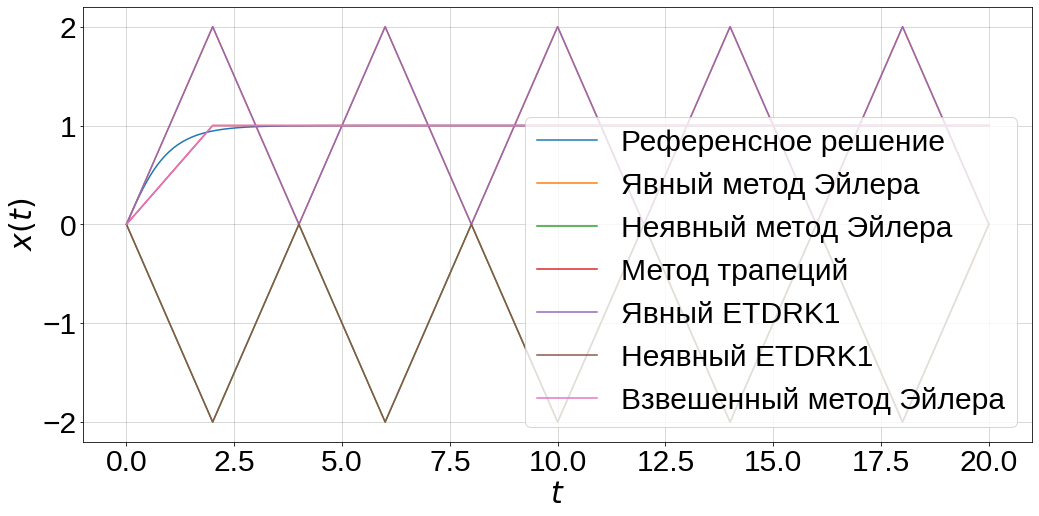

In [22]:
fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(17)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.set_xlabel("$t$")
ax.set_ylabel("$x(t)$")

ax.plot(time_ref, reference, label='Референсное решение')
ax.plot(time, explicit_euler, label='Явный метод Эйлера')
ax.plot(time, implicit_euler, label='Неявный метод Эйлера')
ax.plot(time, trapezoid, label='Метод трапеций')
ax.plot(time, explicit_ETDRK1, label='Явный ETDRK1')
ax.plot(time, implicit_ETDRK1, label='Неявный ETDRK1')
ax.plot(time, weighted_euler, label='Взвешенный метод Эйлера')

ax.legend(loc='lower right')
plt.show();

### Сохранение

In [23]:
import pandas as pd

In [24]:
reference_df = pd.DataFrame()
reference_df['time'] = time_ref
reference_df['reference'] = reference

In [25]:
tests_df = pd.DataFrame()
tests_df['time'] = time
tests_df['explicit_euler'] = explicit_euler
tests_df['implicit_euler'] = implicit_euler
tests_df['trapezoid'] = trapezoid
tests_df['weighted_euler'] = weighted_euler
tests_df['explicit_ETDRK1'] = explicit_ETDRK1
tests_df['implicit_ETDRK1'] = implicit_ETDRK1

In [26]:
path = "../../data/exponential_integrators/"

In [27]:
reference_df.to_csv(path + 'reference.csv', sep='\t', index=False)
tests_df.to_csv(path + 'tests.csv', sep='\t', index=False)